### Building Chatbot With Multiple Tools Using Langgraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [20]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [21]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [22]:
arxiv.invoke("Attention iss all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [23]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [24]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [25]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")



In [26]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [27]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'March 2025: All AI updates from the past month - SD Times',
  'url': 'https://sdtimes.com/ai/march-2025-all-ai-updates-from-the-past-month/',
  'content': 'Google announces Gemma 3\n\nGemma 3 is Google’s latest AI model, offering improved math, reasoning, and chat capabilities. It can handle context windows of up to 128k tokens, understand 140 languages, and comes in four sizes: 1B, 4B, 12B, and 27B.\n\nIt is a multimodal model, and it supports images and videos as inputs, which allows it to analyze images, answer questions about a picture, compare images, identify objects, or reply about text on an image. \n\nGemma 3 is available as either a pre-trained model that can be fine-tuned for specific use cases, or as a general-purpose instruction-tuned model. It is available in Google AI Studio, or can be downloaded through Hugging Face or Kaggle.\n\nOpenAI reveals Responses API, Agents SDK for building agentic experiences [...] Anthropic Console now facilitates prompt collabora

In [28]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily]

In [29]:
## Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen/qwen3-32b")

llm_with_tools=llm.bind_tools(tools)

In [30]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. Let me check the available functions.\n\nThe tools provided are arxiv, wikipedia, and tavily_search_results_json. Arxiv is for scientific papers, which might not be the best fit for general news. Wikipedia is good for general knowledge but might not have the latest updates. The third option is tavily_search_results_json, which is described as a search engine for current events. That sounds like the right choice here since the user is asking for recent news. \n\nSo I should use tavily_search_results_json with a query related to recent AI news. The query parameter should be something like "recent AI news" or "latest AI developments". Let me make sure the parameters are correctly formatted. The function requires a query string, so I\'ll input that. \n\nI need to structure the tool call properly in JSON within the XML tags. Let me double-c

In [31]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI News'},
  'id': 'jevh0twjh',
  'type': 'tool_call'}]

In [32]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

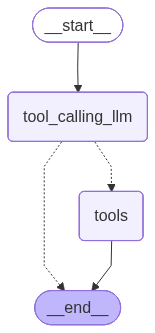

In [33]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [34]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (tqpfzr1vr)
 Call ID: tqpfzr1vr
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [35]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (bc7hxmhnv)
 Call ID: bc7hxmhnv
  Args:
    query: top 10 recent AI news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News | Latest News | Insights Powering AI-Driven Business Growth", "url": "https://www.artificialintelligence-news.com/", "content": "AI News delivers the latest updates in artificial intelligence, machine learning, deep learning, enterprise AI, and emerging tech worldwide.", "score": 0.9851}, {"title": "AI News & Artificial Intelligence - TechCrunch", "url": "https://techcrunch.com/category/artificial-intelligence/", "content": "Read the latest on artificial intelligence and machine learning tech, the companies that are building t

In [36]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (bq1znnewk)
 Call ID: bq1znnewk
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
